In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
# Конфигурация
DATA_DIR = '/content/cars'  # Папка с подпапками 'vw_teramont' и 'volvo_xc70'
MODEL_SAVE_PATH = 'car_classifier.pth'
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
IMAGE_SIZE = 224  # ResNet50 ожидает изображения 224x224


In [5]:
!tar -xzvf /content/sample_data/cars.tar.gz

cars/lexus es250/1200x900 (11).webp
cars/vw teramont/919c85ds-1920.jpg
cars/lexus es250/1200x900 (15).webp
cars/volvo xc70/i (4).webp
cars/volvo xc70/volx7017.jpg
cars/
cars/Audi q5/BBxn1Lk2QvRaYnCaLWC-EQ=s1280.webp
cars/lexus es250/1920x688_16.jpg
cars/Audi q5/i.webp
cars/Audi q5/da0b4es-1920.jpg
cars/lexus es250/314.jpg
cars/volvo xc70/4597b6cs-960.jpg
cars/vw teramont/photo_2024-09-15_15-25-52.jpg
cars/vw teramont/WhatsApp Image 2024-11-05 at 14.40.55.jpeg
cars/volvo xc70/Volvo_XC70_214.jpg
cars/lexus es250/1200x900 (1).webp
cars/lexus es250/1200x900 (9).webp
cars/vw teramont/volkswagen_teramont_1116167.jpg
cars/lexus es250/1200x900 (5).webp
cars/lexus es250/image.webp
cars/volvo xc70/6GLEue-ZYs0.jpg
cars/vw teramont/WhatsApp Image 2024-11-05 at 14.40.53 (1).jpeg
cars/vw teramont/1200x900 (3).webp
cars/Audi q5/1200x900.webp
cars/Audi q5/YY_003.jpg
cars/Audi q5/76de70907bae1018b0ae6eb34b168a45.jpg
cars/volvo xc70/i (1).webp
cars/vw teramont/volkswagen-teramont-i-restajling-.16b669d0b

In [6]:
def prepare_datasets(data_dir):

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    val_dataset.dataset.transform = val_transforms

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    return train_loader, val_loader, full_dataset.classes


In [7]:
def prepare_model(num_classes):
    model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    model = model.to(device)

    return model



In [8]:
def train_model(model, train_loader, val_loader, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_acc = 0.0
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc.cpu().numpy())

        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print('Model saved!')

        print()

    model.load_state_dict(torch.load(MODEL_SAVE_PATH))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.legend()
    plt.title('Loss History')

    plt.subplot(1, 2, 2)
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy History')
    plt.show()

    return model



In [9]:
def validate_model(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(all_labels, all_preds, target_names=class_names))



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Classes: ['Audi q5', 'lexus es250', 'volvo xc70', 'vw teramont']


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

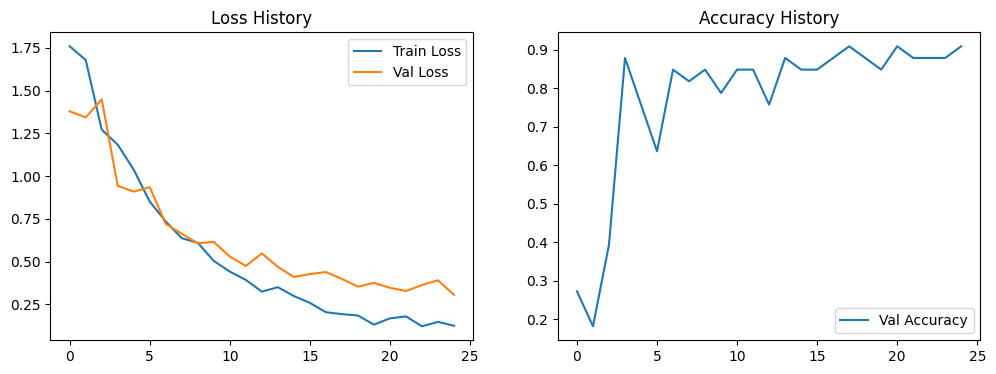

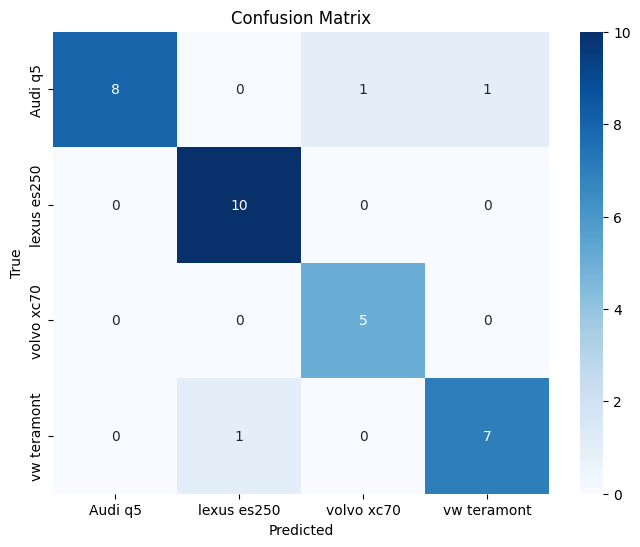

              precision    recall  f1-score   support

     Audi q5       1.00      0.80      0.89        10
 lexus es250       0.91      1.00      0.95        10
  volvo xc70       0.83      1.00      0.91         5
 vw teramont       0.88      0.88      0.88         8

    accuracy                           0.91        33
   macro avg       0.90      0.92      0.91        33
weighted avg       0.92      0.91      0.91        33



In [10]:
# Подготовка данных
train_loader, val_loader, class_names = prepare_datasets(DATA_DIR)
print(f"Classes: {class_names}")

# Подготовка модели
model = prepare_model(len(class_names))
print(model)

# Обучение модели
model = train_model(model, train_loader, val_loader, NUM_EPOCHS)

# Валидация модели
validate_model(model, val_loader, class_names)
